<h1 align="center">研究生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习 M502019B</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">卷积神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">25120323</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">授课老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">原继东</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2025年8月13日</span></div>
</div>

In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch import nn
from torchvision import datasets, transforms
from PIL import Image
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import collections
from typing import Literal, Union, Optional, List

print('Pytorch version:',torch.__version__)
if not torch.cuda.is_available():
    print('CUDA is_available:', torch.cuda.is_available())
else:
    print('CUDA version:', torch.version.cuda)
    print('CUDA device count:', torch.cuda.device_count())
    print('CUDA device name:', torch.cuda.get_device_name())
    print('CUDA device capability:', torch.cuda.get_device_capability())
    print('CUDA device memory:', f'{torch.cuda.get_device_properties(0).total_memory/1024/1024/1024:.2f}', 'GB')
print('CPU count:', cpu_count())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cpu_count = cpu_count()

Pytorch version: 2.7.1+cu118
CUDA version: 11.8
CUDA device count: 1
CUDA device name: NVIDIA TITAN Xp
CUDA device capability: (6, 1)
CUDA device memory: 11.90 GB
CPU count: 8


# 1. 二维卷积实验

- 手写二维卷积的实现，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）（只用循环几轮即可）
- 使用torch.nn实现二维卷积，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
- 不同超参数的对比分析（包括卷积层数、卷积核大小、batchsize、lr等）选其中至少1-2个进行分析
- 使用PyTorch实现经典模型AlexNet并在至少一个数据集进行试验分析

In [2]:
torch.cuda.empty_cache()

创建数据集。

**车辆分类数据集**

- 输入图片，输出对应的类别
- 共1358张车辆图片
- 分别属于汽车、客车和货车三类
    - 汽车：779张
    - 客车：218张
    - 货车：360张
- 每个类别随机取20-30%当作测试集
- 各图片的大小不一，需要将图片拉伸到相同大小

对于原数据集进行`8:2`划分处理。将各个类别的数据分别进行划分。

这里已经将数据集划分完毕，将各部分数据的路径和列表保存在csv文件中。划分代码`dataset/Vehicles/split_dataset.py`内容如下：

```python
import os
import random
import pandas as pd

train_list = list()
test_list = list()

root_dir = "raw"
class_index = 0
for vehicle in os.listdir(root_dir):
    img_list = [i for i in os.listdir(os.path.join(root_dir, vehicle)) if i.endswith(".jpg")]
    random.shuffle(img_list)
    split_num = int(len(img_list) * 0.8)
    for img in img_list[0 : split_num]:
        train_list.append([os.path.join(root_dir, vehicle, img), class_index])
    for img in img_list[split_num : ]:
        test_list.append([os.path.join(root_dir, vehicle, img), class_index])
    class_index += 1

train_list.sort()
test_list.sort()

pd.DataFrame(data=train_list, columns=["Vehicle", "Label"]).to_csv("./train.csv", index=False)
pd.DataFrame(data=test_list, columns=["Vehicle", "Label"]).to_csv("./test.csv", index=False)
```

Vehicle Train Dataset Size: 1085
Vehicle Test Dataset Size: 272
A Train Sample:



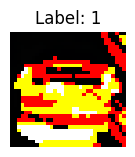

{'Image Type': <class 'torch.Tensor'>, 'Image Shape': torch.Size([3, 32, 32]), 'Label Type': <class 'int'>, 'Label Value': 1}


In [3]:
class Vehicle(Dataset):
    def __init__(self, root: str="./dataset", train: bool=True, transform=None):
        root = os.path.join(root, "Vehicles")
        csv_file = os.path.join(root, "train.csv" if train else "test.csv")
        self.data = pd.read_csv(csv_file)
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        img_name, label = row['Vehicle'], row['Label']
        img_path = os.path.join(self.root, img_name)
        image = Image.open(img_path)
        label = int(label)
        if self.transform:
            image = self.transform(image)
        return image, label

image_size = 32
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
train_vehicle_dataset = Vehicle(root="./dataset", train=True, transform=transform)
test_vehicle_dataset = Vehicle(root="./dataset", train=False, transform=transform)

print('Vehicle Train Dataset Size:', len(train_vehicle_dataset))
print('Vehicle Test Dataset Size:', len(test_vehicle_dataset))

image, label = train_vehicle_dataset[0]
sample = {
    'Image Type': type(image),
    'Image Shape': image.shape,
    'Label Type': type(label),
    'Label Value': label
}
print('A Train Sample:\n')
plt.figure(figsize=(1.5, 1.5))
plt.imshow(image.permute(1, 2, 0).numpy().astype(np.uint8) / 255)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()
print(sample)

num_classes = 3

定义多分类任务的trainer。

In [4]:
class MultiCLSTrainer():
    def __init__(
        self,
        model,
        train_dataset: Union[Dataset, DataLoader],
        eval_dataset: Union[Dataset, DataLoader],
        learning_rate: float,
        num_epochs: int,
        batch_size: int,
        weight_decay: float = 0.0,
        adam_beta1: float = 0.9,
        adam_beta2: float = 0.999,
        test_dataset: Union[Dataset, DataLoader] = None,
        plot: bool = True, 
        print_test_result: bool = True,
        logging_steps: int = 1,
        eval_steps: int = 1,
        print_log_epochs: int = 1,
        print_eval: bool = True
    ):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.plot = plot
        self.print_test_result = print_test_result
        self.logging_steps = logging_steps
        self.eval_steps = eval_steps
        self.print_log_epochs = print_log_epochs
        self.print_eval = print_eval
        
        if isinstance(train_dataset, Dataset):
            self.train_dataloader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                num_workers=cpu_count-1, pin_memory=True
            )
        else:
            self.train_dataloader = train_dataset
        if isinstance(eval_dataset, Dataset):
            self.eval_dataloader = DataLoader(
                dataset=eval_dataset, batch_size=batch_size, shuffle=True, 
                num_workers=cpu_count-1, pin_memory=True
            )
        else:
            self.eval_dataloader = eval_dataset
        if isinstance(test_dataset, Dataset):
            self.test_dataloader = DataLoader(
                dataset=test_dataset, batch_size=batch_size, shuffle=True, 
                num_workers=cpu_count-1, pin_memory=True
            )
        else:
            self.test_dataloader = test_dataset

        self.total_train_steps = self.num_epochs * len(self.train_dataloader)

        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=learning_rate, 
            weight_decay=weight_decay, betas=(adam_beta1, adam_beta2)
        )
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        train_loss_curve = []
        eval_loss_curve = []
        eval_acc_curve = []
        step = 0
        with tqdm(total=self.total_train_steps) as pbar:
            for epoch in range(self.num_epochs):
                total_train_loss = 0
                for x, targets in self.train_dataloader:
                    x = x.to(device=device, dtype=torch.float32)
                    targets = targets.to(device=device, dtype=torch.long)

                    self.optimizer.zero_grad()
                    output = self.model(x)
                    loss = self.criterion(output, targets)
                    total_train_loss += loss.item()
                    if (step + 1) % self.logging_steps == 0:
                        train_loss_curve.append((step + 1, loss.item()))
            
                    loss.backward()
                    self.optimizer.step()
                    step += 1
                    pbar.update(1)

                    if self.eval_steps > 0 and (step + 1) % self.eval_steps == 0:
                        avg_eval_loss, avg_eval_acc = self.eval()
                        eval_loss_curve.append((step + 1, avg_eval_loss))
                        eval_acc_curve.append((step + 1, avg_eval_acc))
                        eval_info = {
                            'Epoch': f'{(step + 1) / len(self.train_dataloader):.1f}/{self.num_epochs}',
                            'Total Valid Loss': f'{avg_eval_loss:.2f}',
                            'Avg Valid Acc': f'{avg_eval_acc:.2%}'
                        }
                        if self.print_eval:
                            print(eval_info)
                if self.print_log_epochs > 0 and (epoch + 1) % self.print_log_epochs == 0:
                    log_info = {
                        'Epoch': f'{(step + 1) / len(self.train_dataloader):.1f}/{self.num_epochs}',
                        'Total Train Loss': f'{total_train_loss:.2f}'
                    }
                    print(log_info)

        return_info = {}
        if self.test_dataloader:
            test_acc = self.test()
            if self.print_test_result:
                print('Avg Test Acc:', f'{test_acc:.2%}')
            return_info['test_acc'] = test_acc
        if self.plot:
            self.plot_results(train_loss_curve, eval_loss_curve, eval_acc_curve)
        return_info['curves'] = {
            'train_loss_curve': train_loss_curve,
            'eval_loss_curve': eval_loss_curve,
            'eval_acc_curve': eval_acc_curve
        }
        return return_info

    def eval(self):
        total_eval_loss = 0
        total_eval_acc = 0
        total_eval_samples = 0
        with torch.inference_mode():
            for x, targets in self.eval_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.long)
                output = self.model(x)
                loss = self.criterion(output, targets)
                total_eval_loss += loss.item()
                preds = nn.functional.softmax(output, dim=1).argmax(dim=1)
                total_eval_acc += (preds == targets).float().sum().item()
                total_eval_samples += targets.numel()
        avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
        avg_eval_acc = total_eval_acc / total_eval_samples
        return avg_eval_loss, avg_eval_acc

    def test(self):
        total_test_acc = 0
        total_test_samples = 0
        with torch.inference_mode():
            for x, targets in self.test_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.long)
                output = self.model(x)
                preds = nn.functional.softmax(output, dim=1).argmax(dim=1)
                total_test_acc += (preds == targets).float().sum().item()
                total_test_samples += targets.numel()
        avg_test_acc = total_test_acc / total_test_samples
        return avg_test_acc
        
    def plot_results(self, train_loss_curve, eval_loss_curve, eval_acc_curve):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        train_log_steps, train_losses = zip(*train_loss_curve)
        axes[0].plot(train_log_steps, train_losses, label='Training Loss', color='blue')
        eval_log_steps, eval_losses = zip(*eval_loss_curve)
        axes[0].plot(eval_log_steps, eval_losses, label='Validation Loss', color='orange')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curve')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

        eval_log_steps, eval_accuracies = zip(*eval_acc_curve)
        axes[1].plot(eval_log_steps, eval_accuracies, label='Validation Accuracy', color='green', marker='o')
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Validation Accuracy Curve')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        plt.tight_layout()
        plt.show()

## 1.1. 题目一

**手写二维卷积的实现，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）（只用循环几轮即可）**

In [5]:
torch.cuda.empty_cache()

在传统的二维卷积中，卷积是通过一个滑动的卷积核进行计算的，这就意味着会有大量的`for`循环，会增加计算的时间复杂度。

对于拥有良好矩阵运算性能的GPU来说，上面的计算可以进行优化，即：将卷积核转化为矩阵，原图像数据也裁剪成对应的矩阵，叠加起来，这样需要多层`for`循环的卷积运算就可以由一次矩阵运算完成。

具体运算流程如下：
1. 将原图像进行`padding`操作；
2. 使用`nn.functional.unfold()`将原图像矩阵重塑为`(batch_size, -1, in_channels, kernel_size, kernel_size)`，其中`-1`会被替代为每张图片裁剪成了多少块，等于传统二维卷积的卷积核循环滑动计算次数；
3. 将卷积核重塑为对应图片碎块的卷积核矩阵；
4. 将两者进行矩阵相乘，一次计算完毕，加上偏置`bias`；
5. 重塑相乘结果，转化为正确的输出矩阵。

代码实现如下。

In [6]:
class My_Conv2d(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int, padding:int=0, bias=True):
        super(My_Conv2d, self).__init__()
        self.has_bias = bias
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        nn.init.xavier_uniform_(self.weight)
        if self.has_bias:
            self.bias = nn.Parameter(torch.zeros(out_channels, requires_grad=True, dtype=torch.float32))

    def forward(self, x):
        batch_size, _, input_height, input_width = x.shape
        if self.padding > 0:
            x = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))
        x = nn.functional.unfold(x, kernel_size=self.kernel_size)
        x = x.permute(0, 2, 1).contiguous()
        weight_unfold = self.weight.view(self.out_channels, -1).t()
        x = torch.matmul(x, weight_unfold)
        if self.has_bias:
            x += self.bias
        output_height = input_height + 2 * self.padding - self.kernel_size + 1
        output_width = input_width + 2 * self.padding - self.kernel_size + 1
        x = x.view(batch_size, output_height, output_width, self.out_channels).permute(0, 3, 1, 2).contiguous()
        return x


class Model_1_1(nn.Module):
    def __init__(self, image_size: int, num_classes=3):
        super(Model_1_1, self).__init__()
        self.net = nn.Sequential(collections.OrderedDict([
            ('conv1', My_Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, bias=False)),
            ('bn1', nn.BatchNorm2d(128)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', My_Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, bias=False)),
            ('bn2', nn.BatchNorm2d(512)),
            ('relu2', nn.ReLU(inplace=True)),
            ('pool', nn.AvgPool2d(image_size)),
            ('flatten', nn.Flatten()),
            ('fc', nn.Linear(in_features=512, out_features=num_classes))
        ]))

    def forward(self, x):
        return self.net(x)

运行测试。

  0%|          | 0/500 [00:00<?, ?it/s]

{'Epoch': '10.0/100', 'Total Valid Loss': '0.52', 'Avg Valid Acc': '83.09%'}
{'Epoch': '20.0/100', 'Total Valid Loss': '0.39', 'Avg Valid Acc': '86.76%'}
{'Epoch': '30.0/100', 'Total Valid Loss': '0.32', 'Avg Valid Acc': '87.50%'}
{'Epoch': '40.0/100', 'Total Valid Loss': '0.31', 'Avg Valid Acc': '88.97%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.32', 'Avg Valid Acc': '90.81%'}
{'Epoch': '60.0/100', 'Total Valid Loss': '0.30', 'Avg Valid Acc': '90.07%'}
{'Epoch': '70.0/100', 'Total Valid Loss': '0.35', 'Avg Valid Acc': '91.54%'}
{'Epoch': '80.0/100', 'Total Valid Loss': '0.25', 'Avg Valid Acc': '90.44%'}
{'Epoch': '90.0/100', 'Total Valid Loss': '0.24', 'Avg Valid Acc': '92.28%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.22', 'Avg Valid Acc': '92.28%'}


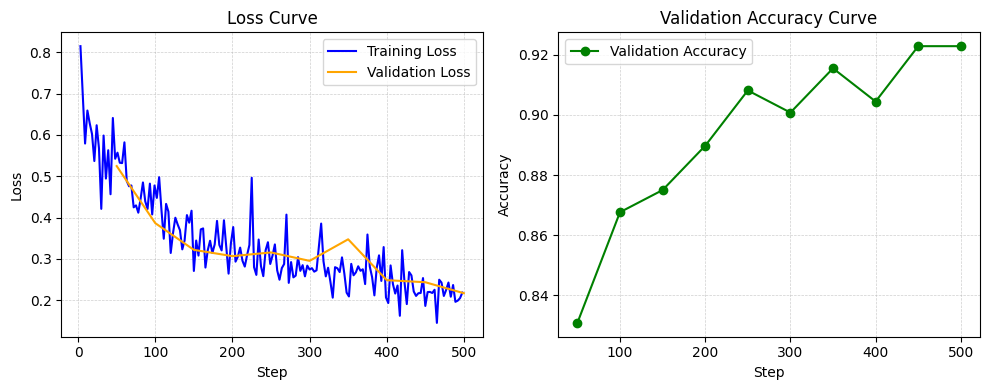

In [7]:
training_args = {
    'train_dataset': train_vehicle_dataset,
    'eval_dataset': test_vehicle_dataset,
    'learning_rate': 2.0e-4,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.01,
    'logging_steps': 3,
    'eval_steps': 50,
    'print_log_epochs': 0
}

model = Model_1_1(image_size=image_size, num_classes=num_classes).to(device)
trainer = MultiCLSTrainer(model=model, **training_args)
_ = trainer.train()

模型能够正常收敛并且达到$90\%$以上的准确率。

## 题目二

**使用torch.nn实现二维卷积，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）**

In [8]:
torch.cuda.empty_cache()

使用上面定义的二维卷积进行车辆分类的训练和预测。

同时，使用`nn.Conv2d`组建相同结构的模型，与手写二维卷积组建的模型进行比较。

  0%|          | 0/500 [00:00<?, ?it/s]

{'Epoch': '10.0/100', 'Total Valid Loss': '0.59', 'Avg Valid Acc': '83.82%'}
{'Epoch': '20.0/100', 'Total Valid Loss': '0.49', 'Avg Valid Acc': '85.29%'}
{'Epoch': '30.0/100', 'Total Valid Loss': '0.42', 'Avg Valid Acc': '87.13%'}
{'Epoch': '40.0/100', 'Total Valid Loss': '0.30', 'Avg Valid Acc': '87.87%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.27', 'Avg Valid Acc': '89.34%'}
{'Epoch': '60.0/100', 'Total Valid Loss': '0.27', 'Avg Valid Acc': '89.71%'}
{'Epoch': '70.0/100', 'Total Valid Loss': '0.26', 'Avg Valid Acc': '90.44%'}
{'Epoch': '80.0/100', 'Total Valid Loss': '0.36', 'Avg Valid Acc': '90.44%'}
{'Epoch': '90.0/100', 'Total Valid Loss': '0.33', 'Avg Valid Acc': '91.18%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.24', 'Avg Valid Acc': '91.91%'}


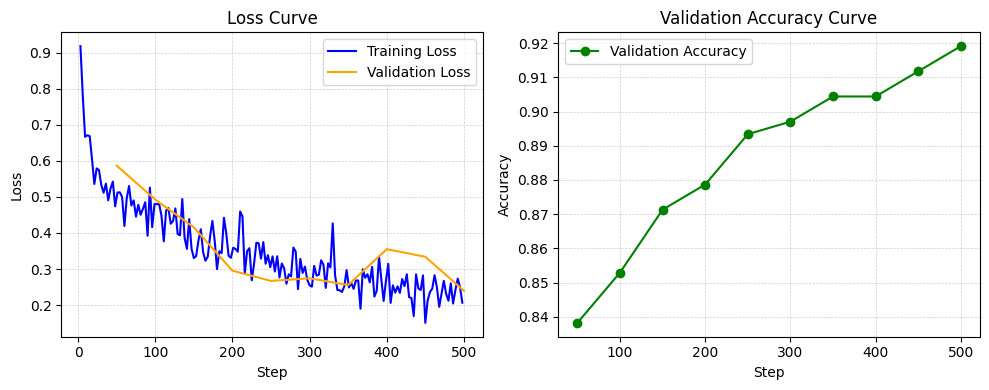

In [9]:
class Model_1_2(nn.Module):
    def __init__(self, image_size: int, num_classes=3):
        super(Model_1_2, self).__init__()
        self.net = nn.Sequential(collections.OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, bias=False)),
            ('bn1', nn.BatchNorm2d(128)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, bias=False)),
            ('bn2', nn.BatchNorm2d(512)),
            ('relu2', nn.ReLU(inplace=True)),
            ('pool', nn.AvgPool2d(image_size)),
            ('flatten', nn.Flatten()),
            ('fc', nn.Linear(in_features=512, out_features=num_classes))
        ]))

    def forward(self, x):
        return self.net(x)


training_args = {
    'train_dataset': train_vehicle_dataset,
    'eval_dataset': test_vehicle_dataset,
    'learning_rate': 2.0e-4,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.1,
    'logging_steps': 3,
    'eval_steps': 50,
    'print_log_epochs': 0
}

model = Model_1_2(image_size=image_size, num_classes=num_classes).to(device)
trainer = MultiCLSTrainer(model=model, **training_args)
_ = trainer.train()

很显然，在车辆分类的任务上，手动实现的二维卷积和`nn.Conv2d`都能够完成任务，且准确率相差不大。

但是`nn.Conv2d`的优化显然比手动实现的好，每个epoch的训练用时和显存占用情况都优于手动实现的二维卷积。

## 1.3. 题目三

**不同超参数的对比分析（包括卷积层数、卷积核大小、batchsize、lr等）选其中至少1-2个进行分析**

In [10]:
torch.cuda.empty_cache()

接下来从**卷积层数**进行对比分析。分别构造具有1、2、3、4个卷积层的模型，进行车辆分类任务的训练和预测。为控制变量，卷积层的输出统一为512个特征，变量为卷积层层数和各卷积层之间out_channels的大小分配。

In [11]:
class Model_1_3(nn.Module):
    def __init__(self, conv_config: list[tuple[int]], image_size: int, num_classes=3):
        super(Model_1_3, self).__init__()
        assert len(conv_config) >= 1
        layers = collections.OrderedDict()
        for i, (in_c, out_c, k, s, p, d) in enumerate(conv_config, start=1):
            layers[f"conv{i}"] = nn.Conv2d(
                in_channels=in_c, out_channels=out_c, kernel_size=k, 
                stride=s, padding=p, dilation=d, bias=False
            )
            layers[f"bn{i}"] = nn.BatchNorm2d(out_c)
            layers[f"relu{i}"] = nn.ReLU(inplace=True)
        layers["avgpool"] = nn.AvgPool2d(image_size)
        layers["flatten"] = nn.Flatten()
        layers["fc"] = nn.Linear(in_features=512, out_features=num_classes)
        self.net = nn.Sequential(layers)

    def forward(self, x):
        return self.net(x)

模型1（1层卷积）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型2（2层卷积）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型3（3层卷积）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型4（4层卷积）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

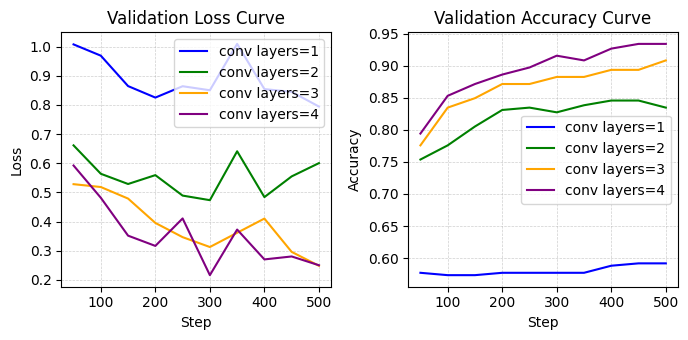

In [12]:
conv_configs = [
    [(3, 512, 3, 1, 1, 1),],
    [(3, 128, 3, 1, 1, 1), (128, 512, 3, 1, 1, 1),],
    [(3, 64, 3, 1, 1, 1), (64, 256, 3, 1, 1, 1), (256, 512, 3, 1, 1, 1),],
    [(3, 64, 3, 1, 1, 1), (64, 128, 3, 1, 1, 1), (128, 256, 3, 1, 1, 1), (256, 512, 3, 1, 1, 1),],
]
plot_colors = ['blue', 'green', 'orange', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

training_args = {
    'train_dataset': train_vehicle_dataset,
    'eval_dataset': test_vehicle_dataset,
    'learning_rate': 2.0e-5,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.1,
    'logging_steps': 3,
    'eval_steps': 50,
    'plot': False,
    'print_log_epochs': 0,
    'print_eval': False
}

for index, conv_config in enumerate(conv_configs):
    model = Model_1_3(conv_config, image_size=image_size, num_classes=num_classes).to(device)
    
    print(f"模型{index + 1}（{len(conv_config)}层卷积）开始训练：")
    trainer = MultiCLSTrainer(model=model, **training_args)
    curves = trainer.train()['curves']

    eval_log_steps, eval_losses = zip(*curves['eval_loss_curve'])
    axes[0].plot(
        eval_log_steps, eval_losses,
        label=f"conv layers={len(conv_config)}", color=plot_colors[index]
    )
    eval_log_steps, eval_accuracies = zip(*curves['eval_acc_curve'])
    axes[1].plot(
        eval_log_steps, eval_accuracies, 
        label=f"conv layers={len(conv_config)}", color=plot_colors[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

模型训练的显存占用、单个epoch的训练/测试时长都随着卷积层的数量增加而增加。

从曲线上看，模型训练的稳定程度随着卷积层数量的增加而增加。

当卷积层数量逐渐增加，正确率提高，说明模型的拟合能力也逐渐提高。

对**卷积核大小**进行比较分析。分别构造卷积核大小为3、5、7、9的模型，进行车辆识别任务的训练和预测。

In [13]:
torch.cuda.empty_cache()

模型1（卷积核大小=3）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型2（卷积核大小=5）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型3（卷积核大小=7）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型4（卷积核大小=9）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

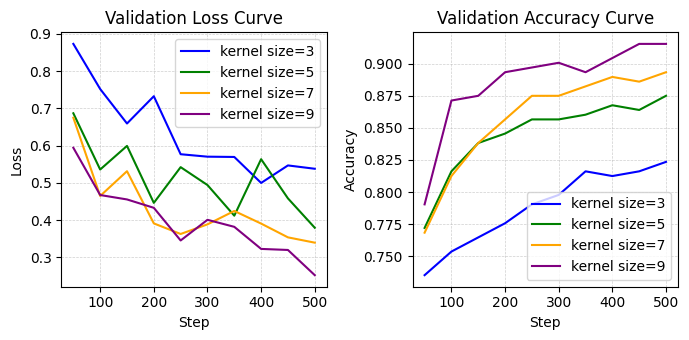

In [14]:
conv_configs = [
    [(3, 128, 3, 1, 1, 1), (128, 512, 3, 1, 1, 1),],
    [(3, 128, 5, 1, 2, 1), (128, 512, 5, 1, 2, 1),],
    [(3, 128, 7, 1, 3, 1), (128, 512, 7, 1, 3, 1),],
    [(3, 128, 9, 1, 4, 1), (128, 512, 9, 1, 4, 1),]
]
plot_colors = ['blue', 'green', 'orange', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

training_args = {
    'train_dataset': train_vehicle_dataset,
    'eval_dataset': test_vehicle_dataset,
    'learning_rate': 1.0e-5,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.1,
    'logging_steps': 3,
    'eval_steps': 50,
    'plot': False,
    'print_log_epochs': 0,
    'print_eval': False
}

for index, conv_config in enumerate(conv_configs):
    model = Model_1_3(conv_config, image_size=image_size, num_classes=num_classes).to(device)
    
    print(f"模型{index + 1}（卷积核大小={conv_config[0][2]}）开始训练：")
    trainer = MultiCLSTrainer(model=model, **training_args)
    curves = trainer.train()['curves']

    eval_log_steps, eval_losses = zip(*curves['eval_loss_curve'])
    axes[0].plot(
        eval_log_steps, eval_losses,
        label=f"kernel size={conv_config[0][2]}", color=plot_colors[index]
    )
    eval_log_steps, eval_accuracies = zip(*curves['eval_acc_curve'])
    axes[1].plot(
        eval_log_steps, eval_accuracies, 
        label=f"kernel size={conv_config[0][2]}", color=plot_colors[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

随着卷积核的增大，训练时长增加，显存占用也增加，性能也增加。这是由于卷积核增大，参数量增加的结果。

## 1.4. 题目四

**使用PyTorch实现经典模型AlexNet并在至少一个数据集进行试验分析**

In [15]:
torch.cuda.empty_cache()

构建AlexNet网络。为匹配车辆识别数据集，输出维度为3。

  0%|          | 0/500 [00:00<?, ?it/s]

{'Epoch': '10.0/100', 'Total Valid Loss': '0.88', 'Avg Valid Acc': '57.35%'}
{'Epoch': '20.0/100', 'Total Valid Loss': '0.40', 'Avg Valid Acc': '85.66%'}
{'Epoch': '30.0/100', 'Total Valid Loss': '0.41', 'Avg Valid Acc': '89.71%'}
{'Epoch': '40.0/100', 'Total Valid Loss': '0.26', 'Avg Valid Acc': '90.07%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.21', 'Avg Valid Acc': '92.28%'}
{'Epoch': '60.0/100', 'Total Valid Loss': '0.25', 'Avg Valid Acc': '91.91%'}
{'Epoch': '70.0/100', 'Total Valid Loss': '0.21', 'Avg Valid Acc': '89.71%'}
{'Epoch': '80.0/100', 'Total Valid Loss': '0.20', 'Avg Valid Acc': '92.28%'}
{'Epoch': '90.0/100', 'Total Valid Loss': '0.36', 'Avg Valid Acc': '93.38%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.16', 'Avg Valid Acc': '92.65%'}


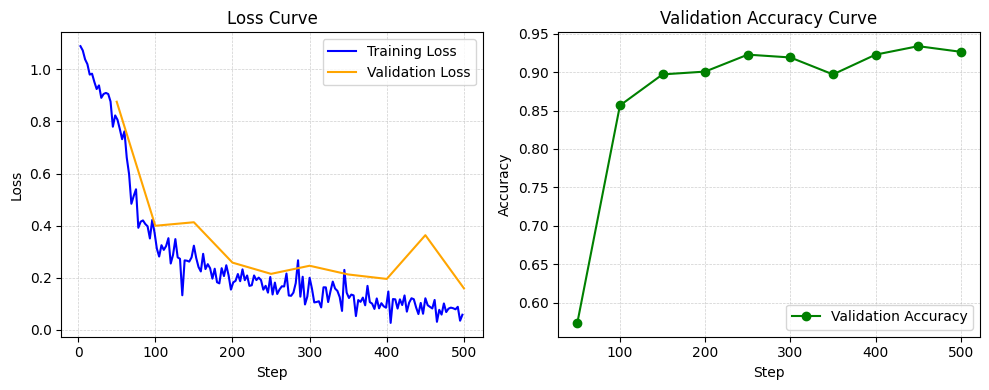

In [16]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(collections.OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)), # 55 * 55
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=3, stride=2)), # 27 * 27
            ('conv2', nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)), # 27 * 27
            ('relu2', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool2d(kernel_size=3, stride=2)), # 13 * 13
            ('conv3', nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)), # 13 * 13
            ('relu3', nn.ReLU(inplace=True)),
            ('conv4', nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)), # 13 * 13
            ('relu4', nn.ReLU(inplace=True)),
            ('conv5', nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)), # 13 * 13
            ('relu5', nn.ReLU(inplace=True)),
            ('pool5', nn.MaxPool2d(kernel_size=3, stride=2)), # 6 * 6
        ]))
        self.classifier = nn.Sequential(collections.OrderedDict([
            ('fc6', nn.Linear(in_features=9216, out_features=4096)),
            ('relu6', nn.ReLU(inplace=True)),
            ('dropout6', nn.Dropout(p=0.5)),
            ('fc7', nn.Linear(in_features=4096, out_features=4096)),
            ('relu7', nn.ReLU(inplace=True)),
            ('dropout7', nn.Dropout(p=0.5)),
            ('fc8', nn.Linear(in_features=4096, out_features=3)),
        ]))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


alexnet_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((227, 227), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
train_alexnet_dataset = Vehicle(root="./dataset", train=True, transform=alexnet_transform)
test_alexnet_dataset = Vehicle(root="./dataset", train=False, transform=alexnet_transform)

training_args = {
    'train_dataset': train_alexnet_dataset,
    'eval_dataset': test_alexnet_dataset,
    'learning_rate': 1.0e-5,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 5.0e-5,
    'logging_steps': 3,
    'eval_steps': 50,
    'print_log_epochs': 0
}

model = AlexNet().to(device)
trainer = MultiCLSTrainer(model=model, **training_args)
_ = trainer.train()

实验表明，AlexNet在车辆识别数据集上能够正常收敛，且准确率达到了$90\%$以上。但是由于模型复杂度较高，训练到最后存在过拟合问题。可以通过增加dropout层缓解这个问题。

# 2. 空洞卷积实验

- 使用torch.nn实现空洞卷积，要求dilation满足HDC条件（如1,2,5）且要堆叠多层并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
- 将空洞卷积模型的实验结果与卷积模型的结果进行分析比对，训练时间、预测精度、Loss变化等角度分析
- 不同超参数的对比分析（包括卷积层数、卷积核大小、不同dilation的选择，batchsize、lr等）选其中至少1-2个进行分析（选做）

In [17]:
torch.cuda.empty_cache()

对**dilation**进行比较分析。分别构造dilation为
- \[\[1, 1, 1\], \[1, 1, 1\]\]（普通卷积）
- \[\[1, 2, 5\], \[1, 2, 5\]\]
- \[\[1, 3, 5\], \[1, 3, 5\]\]
- \[\[1, 3, 7\], \[1, 3, 7\]\]

的模型，进行车辆分类任务的训练和预测。为控制变量，`channels`的变化统一为\[3, 16, 32, 64, 128, 256, 512\]。

模型1（dilation=[1, 1, 1]）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型2（dilation=[1, 2, 5]）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型3（dilation=[1, 3, 5]）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

模型4（dilation=[1, 3, 7]）开始训练：


  0%|          | 0/500 [00:00<?, ?it/s]

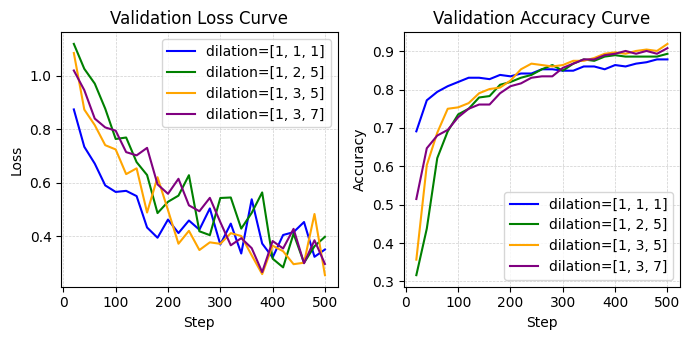

In [18]:
conv_configs = [
    [(3, 16, 3, 1, 1, 1), (16, 32, 3, 1, 1, 1), (32, 64, 3, 1, 1, 1), 
        (64, 128, 3, 1, 1, 1), (128, 256, 3, 1, 1, 1), (256, 512, 3, 1, 1, 1),],
    [(3, 16, 3, 1, 1, 1), (16, 32, 3, 1, 2, 2), (32, 64, 3, 1, 5, 5), 
        (64, 128, 3, 1, 1, 1), (128, 256, 3, 1, 2, 2), (256, 512, 3, 1, 5, 5),],
    [(3, 16, 3, 1, 1, 1), (16, 32, 3, 1, 3, 3), (32, 64, 3, 1, 5, 5), 
        (64, 128, 3, 1, 1, 1), (128, 256, 3, 1, 3, 3), (256, 512, 3, 1, 5, 5),],
    [(3, 16, 3, 1, 1, 1), (16, 32, 3, 1, 3, 3), (32, 64, 3, 1, 7, 7), 
        (64, 128, 3, 1, 1, 1), (128, 256, 3, 1, 3, 3), (256, 512, 3, 1, 7, 7),],
]
plot_colors = ['blue', 'green', 'orange', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

training_args = {
    'train_dataset': train_vehicle_dataset,
    'eval_dataset': test_vehicle_dataset,
    'learning_rate': 5.0e-6,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.1,
    'logging_steps': 3,
    'eval_steps': 20,
    'plot': False,
    'print_log_epochs': 0,
    'print_eval': False
}

for index, conv_config in enumerate(conv_configs):
    model = Model_1_3(conv_config, image_size=image_size, num_classes=num_classes).to(device)
    dilation_str = f'dilation=[{conv_config[0][5]}, {conv_config[1][5]}, {conv_config[2][5]}]'
    
    print(f"模型{index + 1}（{dilation_str}）开始训练：")
    trainer = MultiCLSTrainer(model=model, **training_args)
    curves = trainer.train()['curves']

    eval_log_steps, eval_losses = zip(*curves['eval_loss_curve'])
    axes[0].plot(
        eval_log_steps, eval_losses,
        label=dilation_str, color=plot_colors[index]
    )
    eval_log_steps, eval_accuracies = zip(*curves['eval_acc_curve'])
    axes[1].plot(
        eval_log_steps, eval_accuracies, 
        label=dilation_str, color=plot_colors[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

从loss曲线和准确率曲线来看，4种dilation配置最终都能够收敛到较好的结果（准确率$90\%$左右），导致的原因是模型复杂度高而训练数据量少。

但是从收敛速度来看，准确率曲线左端，dilation为$[1, 3, 7]$的模型在第一次验证时就已经达到约$70\%$的准确率，相比之下普通卷积的准确率还不到$50\%$，其他两种配置的准确率介于两者之间；验证集loss同理。

说明dilation跨度越大的模型，收敛越快，空洞卷积模型有更好的拟合能力。

从训练速度来看，dilation的模型训练时长显著多于普通卷积，猜测是改变图形形状适配空洞卷积核的步骤会耗费较多的算力。

# 3. 残差网络实验

- 实现给定结构的残差网络，在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）


In [19]:
torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

{'Epoch': '10.0/100', 'Total Valid Loss': '0.49', 'Avg Valid Acc': '85.29%'}
{'Epoch': '20.0/100', 'Total Valid Loss': '0.30', 'Avg Valid Acc': '91.54%'}
{'Epoch': '30.0/100', 'Total Valid Loss': '0.37', 'Avg Valid Acc': '91.91%'}
{'Epoch': '40.0/100', 'Total Valid Loss': '0.32', 'Avg Valid Acc': '91.91%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.18', 'Avg Valid Acc': '92.28%'}
{'Epoch': '60.0/100', 'Total Valid Loss': '0.38', 'Avg Valid Acc': '92.65%'}
{'Epoch': '70.0/100', 'Total Valid Loss': '0.22', 'Avg Valid Acc': '91.18%'}
{'Epoch': '80.0/100', 'Total Valid Loss': '0.69', 'Avg Valid Acc': '92.28%'}
{'Epoch': '90.0/100', 'Total Valid Loss': '0.27', 'Avg Valid Acc': '92.28%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.28', 'Avg Valid Acc': '92.28%'}


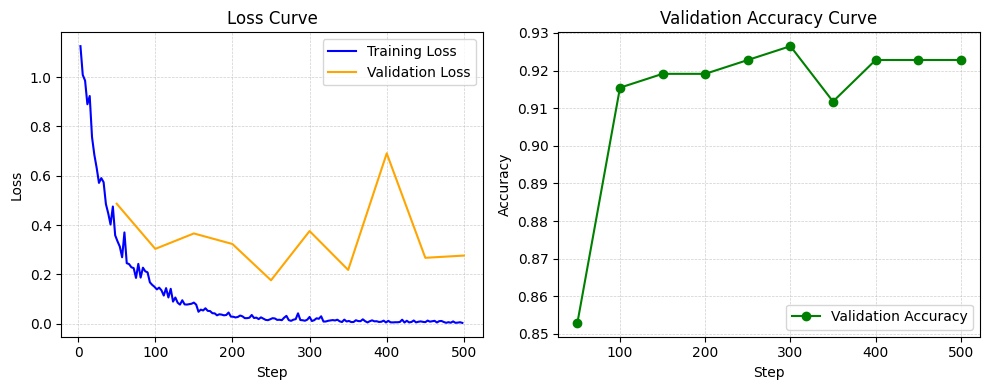

In [20]:
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return self.relu(self.conv2(self.conv1(x)) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet, self).__init__()
        self.features = nn.Sequential(collections.OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)),
            ('bn1', nn.BatchNorm2d(64)),
            ('relu1', nn.ReLU(inplace=True)),
            ('resnet_block2', BasicResidualBlock(in_channels=64, out_channels=64)),
            ('resnet_block3', BasicResidualBlock(in_channels=64, out_channels=64)),
            ('resnet_block4', BasicResidualBlock(in_channels=64, out_channels=128, stride=2)),
            ('resnet_block5', BasicResidualBlock(in_channels=128, out_channels=128)),
            ('resnet_block6', BasicResidualBlock(in_channels=128, out_channels=256, stride=2)),
            ('resnet_block7', BasicResidualBlock(in_channels=256, out_channels=256)),
            ('resnet_block8', BasicResidualBlock(in_channels=256, out_channels=512, stride=2)),
            ('resnet_block9', BasicResidualBlock(in_channels=512, out_channels=512)),
            ('pool', nn.AvgPool2d(4)),
        ]))
        self.classifier = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(torch.flatten(x, 1))
        return x


training_args = {
    'train_dataset': train_vehicle_dataset,
    'eval_dataset': test_vehicle_dataset,
    'learning_rate': 5.0e-6,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.1,
    'logging_steps': 3,
    'eval_steps': 50,
    'print_log_epochs': 0
}
model = ResNet(num_classes=num_classes).to(device)
trainer = MultiCLSTrainer(model=model, **training_args)
_ = trainer.train()

实验证明，残差网络的效果比纯卷积网络好。原因在于残差网络能保留原图片输入的大部分特征，不会在卷积计算中遗漏。

但是由于网络复杂度比较高，模型出现了过拟合，可以加入dropout缓解。

# 心得体会

通过本次卷积神经网络实验，我深入理解和掌握了卷积神经网络的原理，并且在多个数据集上设计并训练了不同结构的卷积神经网络模型，通过比较分析不同模型的性能，加深了我对卷积神经网络中不同组件作用的理解。

实验中，我实现了自定义的二维卷积运算，并在车辆分类任务上与PyTorch内置的二维卷积运算进行了比较。这让我深入理解了卷积运算转换为矩阵运算的过程，以及GPU对矩阵运算的加速优化。我也对比研究了卷积层数、卷积核大小等超参数对模型性能的影响。

通过对dilation参数的研究，我意识到在神经网络设计中参数选择的细微差别可能导致显著的性能变化。特别是在对比普通卷积和不同dilation配置的空洞卷积时，我观察到虽然较高的dilation在一开始的学习效率和准确率方面可能不如普通卷积，但随着训练的进行，它们能更好地拟合数据且较不易过拟合。这种洞见对我理解如何平衡网络的学习速度和泛化能力非常有帮助。

此外，通过残差网络的实验，我学到了网络结构设计的重要性。残差网络能够有效地解决深度网络训练过程中的梯度消失问题，同时保留更多的原始特征信息。这一点在实验中得到了明显的体现，残差网络在几乎所有指标上都优于传统的纯卷积网络。

在实验过程中，我也遇到了一些挑战，比如调整网络参数以避免过拟合，以及理解不同网络结构背后的理论基础。通过不断尝试和阅读相关文献，我逐步克服了这些难题，并对这些概念有了更深刻的理解。

通过整个实验，我掌握了卷积神经网络的组成结构，了解了调节不同超参数对模型性能的影响，加深了对卷积神经网络代表性结构的理解，为后续课程项目奠定了基础。我会在今后的学习中进一步深化对卷积神经网络的研究，运用到更多实际问题中。这次实验不仅增强了我的技术技能，也加深了我对深度学习领域的热情和认识。我期待未来能在这一领域继续探索和成长。